In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import os
from tensorflow.keras.models import load_model
from Transformer import rmse, smape, coeff_determination
from Transformer import Transformer
from numpy.fft import *
from utils import *
import json

In [23]:
expo_preds = pd.read_csv('expsmooth_preds4.csv')
tbats_preds = pd.read_csv('tbats_preds4.csv')
tr_preds = pd.read_csv('Transformer_preds_2.csv')
prophet_preds = pd.read_csv('prophet_preds4.csv')

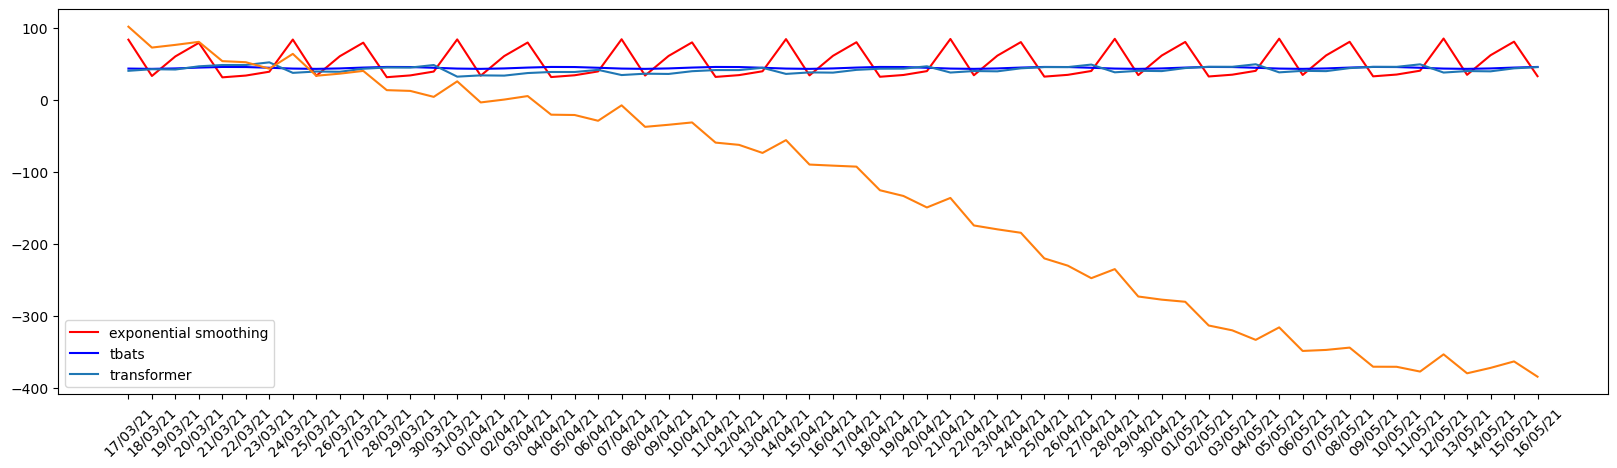

In [7]:
wh_id = prophet_preds['wh_id'].unique()[15]
plt.figure(figsize=(20, 5))
plt.xticks(rotation = 45)
plt.plot(expo_preds['date'].unique(), expo_preds.loc[expo_preds['wh_id']==wh_id]['sales'], 'r')
plt.plot(tbats_preds['date'].unique(), tbats_preds.loc[tbats_preds['wh_id']==wh_id]['sales'], 'b')
plt.plot(tr_preds['date'].unique(), tr_preds.loc[tr_preds['wh_id']==wh_id]['sales'])
plt.plot(prophet_preds['date'].unique(), prophet_preds.loc[prophet_preds['wh_id']==wh_id]['sales'])
plt.legend(['exponential smoothing', 'tbats', 'transformer'])
#29/03/21 06/4/21 , 12/04/21 21/04/21

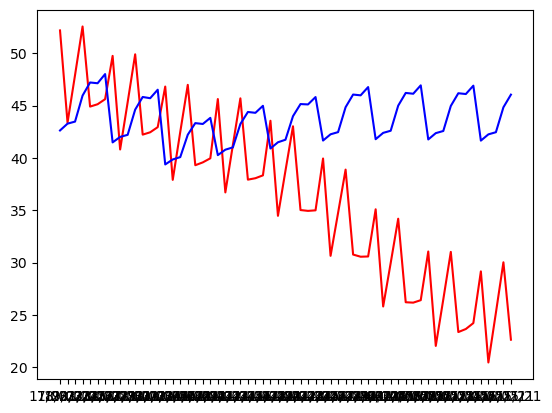

In [8]:
plt.plot(expo_preds['date'].unique(), 0.6*tbats_preds.loc[tbats_preds['wh_id']==wh_id]['sales']+0.2*tr_preds.loc[tr_preds['wh_id']==wh_id]['sales']+0.15*expo_preds.loc[expo_preds['wh_id']==wh_id]['sales']+0.05*prophet_preds.loc[prophet_preds['wh_id']==wh_id]['sales'], 'r')
plt.plot(expo_preds['date'].unique(), 0.6*tbats_preds.loc[tbats_preds['wh_id']==wh_id]['sales']+0.4*tr_preds.loc[tr_preds['wh_id']==wh_id]['sales'], 'b')

In [5]:
df_new = 0.6*tbats_preds.loc[tbats_preds['wh_id']==wh_id]['sales']+0.2*tr_preds.loc[tr_preds['wh_id']==wh_id]['sales']+0.15*expo_preds.loc[expo_preds['wh_id']==wh_id]['sales']+0.05*prophet_preds.loc[prophet_preds['wh_id']==wh_id]['sales']

In [24]:
df_2 = prophet_preds.copy()

In [25]:
df_2['sales'] = 0.05*df_2['sales'] + 0.6*tr_preds['sales'] + 0.2*tbats_preds['sales']+ 0.15*expo_preds['sales']

In [27]:
df_2.drop('Unnamed: 0', axis=1, inplace=True)

In [29]:
df_2.to_csv('ensemble_4_models.csv')

In [24]:
model_lst = sorted(os.listdir('models_folder'))

In [38]:
rmse_dict = dict()

In [26]:
def preprocess1(df):
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df.set_index(['date'], inplace=True)
    df.drop(columns=['Unnamed: 0', 'wh_id'], inplace=True)
    return df

In [27]:
def preprocess2(daily_data):
    daily_data['day'] = pd.DatetimeIndex(daily_data.index).day
    daily_data['weekday'] = ((pd.DatetimeIndex(daily_data.index).dayofweek) // 5 == 1).astype(float)
    daily_data['season'] = [month%12 // 3 + 1 for month in pd.DatetimeIndex(daily_data.index).month]
    daily_data.drop(columns='weekday', inplace=True)
    return daily_data

In [28]:
def filter_signal(signal, threshold=3e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/(signal.size))
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [29]:
def tt_split(daily_data):
    look_back = 7
    n_features = daily_data.shape[1]

    # Walk-forward data split to avoid data leakage
    X_train, y_train, X_test, y_test, scale_X = series_to_supervised(daily_data, train_size=0.8, n_in=look_back, n_out=7, target_column='sales', dropnan=True, scale_X=True)

    # reshape input to be 3D [samples, timesteps, features]
    X_train_reshaped = X_train.values.reshape((-1,look_back,n_features))
    X_test_reshaped = X_test.values.reshape((-1,look_back,n_features))

    y_train_reshaped = y_train.values
    y_test_reshaped = y_test.values
    return X_train, X_train_reshaped, X_test, X_test_reshaped, y_train, y_train_reshaped, y_test, y_test_reshaped

In [30]:
wh_dataLst = sorted(os.listdir('../dataset/wh_wise_data/train/'))

In [79]:
x = load_model('models_folder/wh_1.hdf5', custom_objects={'rmse':rmse, 'smape':smape, 'coeff_determination':coeff_determination})

In [31]:
for m in tqdm(model_lst):
    model = load_model('models_folder/'+m, custom_objects={'rmse':rmse, 'smape':smape, 'coeff_determination':coeff_determination})
    id = m.split('.')[0]
    df = pd.read_csv('../dataset/wh_wise_data/train/train_'+id+'.csv')
    x = df['sales']
    df = df[:-1]
    df['sales'] = x
    df = preprocess2(preprocess1(df))
    X_train, X_train_reshaped, X_test, X_test_reshaped, y_train, y_train_reshaped, y_test, y_test_reshaped = tt_split(df)
    preds = model.predict(X_train_reshaped)
    metric = rmse(preds, y_train)
    rmse_lst[id] = metric

  0%|          | 0/559 [00:00<?, ?it/s]

804
21/21 [==============================] - 4s 33ms/step
804
21/21 [==============================] - 2s 28ms/step
804
21/21 [==============================] - 1s 26ms/step
804
21/21 [==============================] - 2s 30ms/step
804
21/21 [==============================] - 1s 28ms/step
804
21/21 [==============================] - 1s 28ms/step
804
21/21 [==============================] - 1s 28ms/step
804
21/21 [==============================] - 1s 26ms/step
804
21/21 [==============================] - 1s 27ms/step
804
21/21 [==============================] - 1s 28ms/step
804
21/21 [==============================] - 1s 26ms/step
804
21/21 [==============================] - 1s 29ms/step
804
21/21 [==============================] - 2s 28ms/step
804
21/21 [==============================] - 2s 26ms/step
804
21/21 [==============================] - 1s 29ms/step
804
21/21 [==============================] - 2s 28ms/step
804
21/21 [==============================] - 1s 27ms/step
804
21/21 [===

KeyboardInterrupt: 

In [91]:
for i in trange(len(rmse_lst)):
    rmse_lst[i] = rmse_lst[i].numpy()

  0%|          | 0/559 [00:00<?, ?it/s]

In [97]:
# with open('transformer_metrics.json', 'w') as f:
#     rmse_json = json.dump(rmse_lst, f)

In [32]:
with open('transformer_metrics.json', 'r') as f:
    met = json.load(f)

In [34]:
id_lst = [x.split('_')[2][:-4] for x in wh_dataLst]

In [40]:
for i in range(len(id_lst)):
    rmse_dict[id_lst[i]] = met[i]

In [43]:
import json

In [44]:
with open('transformer_metrics_dict.json', 'w') as f:
    rmse_json = json.dump(rmse_dict, f)

In [56]:
weights = {'tr':[], 'prophet':[], 'expo':[], 'tbats':[]}
for error in tqdm(met):

    if error>250:
        weights['tr'].append(0.1)
        weights['tbats'].append(0.8)
        weights['prophet'].append(0)
        weights['expo'].append(0.1)

    elif error>170:
        weights['tr'].append(0.3)
        weights['tbats'].append(0.6)
        weights['prophet'].append(0)
        weights['expo'].append(0.1)

    elif error<=170:
        weights['tr'].append(0.6)
        weights['tbats'].append(0.35)
        weights['prophet'].append(0.0)
        weights['expo'].append(0.05)
    

  0%|          | 0/559 [00:00<?, ?it/s]

In [50]:
id_lst = [int((x.split('.')[0]).split('_')[1]) for x in model_lst]

In [57]:
df_new = tr_preds.copy()

In [51]:
tr_preds

,date,wh_id,sales
0,17/03/21,1,55.908112
1,18/03/21,1,58.796329
2,19/03/21,1,61.410175
3,20/03/21,1,64.469322
4,21/03/21,1,68.192871
...,...,...,...
34094,12/05/21,97,95.418114
34095,13/05/21,97,98.591644
34096,14/05/21,97,103.069405
34097,15/05/21,97,108.227127


In [52]:
id_lst.index(1)

0

In [58]:
for index, row in tqdm(tr_preds.iterrows()):
    wh_idx = id_lst.index(df_new.loc[index, 'wh_id'])
    df_new['sales'][index] = tr_preds['sales'][index]*weights['tr'][wh_idx] + prophet_preds['sales'][index]*weights['prophet'][wh_idx] + expo_preds['sales'][index]*weights['expo'][wh_idx] + tbats_preds['sales'][index]*weights['tbats'][wh_idx]

0it [00:00, ?it/s]

C:\Users\hp\AppData\Local\Temp\ipykernel_18340\726364495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['sales'][index] = tr_preds['sales'][index]*weights['tr'][wh_idx] + prophet_preds['sales'][index]*weights['prophet'][wh_idx] + expo_preds['sales'][index]*weights['expo'][wh_idx] + tbats_preds['sales'][index]*weights['tbats'][wh_idx]


In [59]:
df_new

,date,wh_id,sales
0,17/03/21,1,56.515172
1,18/03/21,1,60.008636
2,19/03/21,1,63.470768
3,20/03/21,1,65.803153
4,21/03/21,1,66.486125
...,...,...,...
34094,12/05/21,97,85.834679
34095,13/05/21,97,87.784628
34096,14/05/21,97,88.826669
34097,15/05/21,97,94.798528


In [182]:
(np.array(rmse_lst)>250).sum()

135

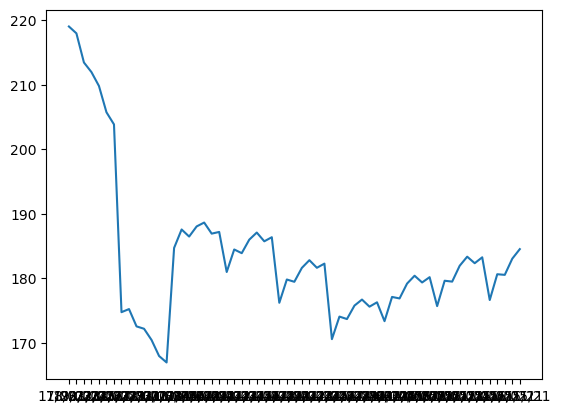

In [61]:
plt.plot(df_new['date'].unique(), df_new.loc[df_new['wh_id']==prophet_preds['wh_id'].unique()[100]]['sales'])

In [60]:
df_new.to_csv('ensemble_4_models_2.csv')

In [5]:
from darts import TimeSeries

In [6]:
import darts

In [7]:
from darts.models import ExponentialSmoothing

OSError: [WinError 182] The operating system cannot run %1. Error loading "d:\anaconda3\envs\tensorflow\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
TRAIN_PATH = '../dataset/wh_wise_data/train/'
TEST_PATH = '../dataset/wh_wise_data/test/'

In [6]:
wh_tr = os.listdir(TRAIN_PATH)
wh_tst = os.listdir(TEST_PATH)

In [14]:
mean_lst = []

In [209]:
df['sales'][-700:].mean()

340.6457142857143

In [202]:
for wh in wh_tr:
    df = pd.read_csv(TRAIN_PATH+wh)
    mean_lst.append(df['sales'][-700:].mean())

In [203]:
mean_lst

[25.449612403100776,
 49.64341085271318,
 30.617571059431526,
 39.16020671834625,
 48.75968992248062,
 20.643410852713178,
 38.708010335917315,
 29.37984496124031,
 34.49095607235142,
 24.162790697674417,
 21.532299741602067,
 17.527131782945737,
 19.56330749354005,
 65.02325581395348,
 26.718346253229974,
 19.248062015503876,
 39.78811369509044,
 20.839793281653748,
 43.45219638242894,
 28.723514211886304,
 54.70542635658915,
 40.76227390180878,
 26.878552971576227,
 14.785529715762275,
 10.661498708010337,
 20.529715762273902,
 91.91731266149871,
 13.635658914728682,
 18.71576227390181,
 17.968992248062015,
 35.361757105943155,
 22.76485788113695,
 18.372093023255815,
 20.356589147286822,
 30.599483204134366,
 17.198966408268735,
 24.242894056847547,
 36.93798449612403,
 31.651162790697676,
 14.113695090439277,
 32.69767441860465,
 30.906976744186046,
 74.20671834625323,
 21.328165374677003,
 14.018087855297157,
 20.449612403100776,
 16.27390180878553,
 50.2609819121447,
 58.91731266

In [58]:
df_x = pd.read_csv('test_pred.csv')

In [59]:
whids = [int(x.split('_')[2][:-4]) for x in wh_tr]

In [60]:
for index, row in df_x.iterrows():
    if row['sales'][index]>mean_lst[whids.index(row['wh_id'])]+40:
        df_x['sales'][index] = mean_lst[whids.index(row['wh_id'])]

C:\Users\hp\AppData\Local\Temp\ipykernel_22548\902889722.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['sales'][index] = 70
C:\Users\hp\AppData\Local\Temp\ipykernel_22548\902889722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['sales'][index] = min(mean_lst[whids.index(row['wh_id'])]+40, 70)
C:\Users\hp\AppData\Local\Temp\ipykernel_22548\902889722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['sales'][i

In [61]:
df_x.to_csv('test_preds2.csv')

In [193]:
df_2 = pd.read_csv('test_preds2.csv')

In [194]:
df_2.drop('Unnamed: 0', axis=1, inplace=True)

In [195]:
df_2['date'] = df_2['date'].map(lambda d: '/'.join(d.split('-')))

In [77]:
df_2['sales'] = df_2['sales'].map(lambda x:70 if x<0 else x)

In [196]:
df_2

,date,wh_id,sales
0,17/03/21,1,55.908112
1,18/03/21,1,58.796329
2,19/03/21,1,61.410175
3,20/03/21,1,64.469322
4,21/03/21,1,57.612775
...,...,...,...
34094,12/05/21,97,50.713197
34095,13/05/21,97,57.185013
34096,14/05/21,97,52.328893
34097,15/05/21,97,87.584606


In [197]:
df_2.to_csv('test_preds3mods.csv')

In [173]:
df_2['sales'] = df_2['sales'].map(lambda x: 100 if x>100 else x)

In [199]:
df_2.loc[df_2['sales']>500]['wh_id'].unique()

array([1177, 1323,  189,  240,  315,  338,  578,  768,  780,  847],
      dtype=int64)

In [205]:
mean_lst[whids.index(1177)]

69.75710594315245

In [153]:
df_2.loc[df_2['sales']<=-40]['wh_id'].unique()

array([1379, 1383, 1415], dtype=int64)

In [168]:
df_2['sales'] = df_2['sales'].map(lambda x: abs(x) if x<0 and x>-40 else x)
# df_2['sales'] = df_2['sales'].map(lambda x: )


In [167]:
for index, row in df_2.iterrows():
    if row['wh_id']==1415:
        df_2.at[index, 'sales'] = 125.978
    if row['wh_id']==1379:
        df_2.at[index, 'sales'] = 33.75
    if row['wh_id']==1383:
        df_2.at[index, 'sales'] = 38.203
    if row['sales']<-40:
        df_2.at[index, 'sales'] = 10
    if row['sales']>=-40 and row['sales']<0:
        df_2.at[index, 'sales'] = abs(row['sales'])
    if row['sales']>500:
        df_2.at[index, 'sales'] = 300
    


In [156]:
mean_lst[whids.index(1383)]

0.0103359173126615

In [169]:
df_2.loc[df_2['wh_id']==1415]

,date,wh_id,sales
13542,17/03/21,1415,125.978
13543,18/03/21,1415,125.978
13544,19/03/21,1415,125.978
13545,20/03/21,1415,125.978
13546,21/03/21,1415,125.978
...,...,...,...
13598,12/05/21,1415,125.978
13599,13/05/21,1415,125.978
13600,14/05/21,1415,125.978
13601,15/05/21,1415,125.978


In [175]:
df_2.to_csv('test_pred3.csv')

In [180]:
[x for x in mean_lst if x>100]

[129.04134366925064,
 125.04651162790698,
 157.50904392764858,
 111.53229974160207,
 140.23514211886305,
 109.29198966408269,
 255.7751937984496]